In [36]:
import warnings
import intake
import xarray as xr
import proplot as plot
import pandas as pd
import cftime
import GPy
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

warnings.filterwarnings('ignore')

# Fitting a Gaussian process to UKESM climate data

Table of contents:
- [1. Preparing the data](#1.-Preparing-the-data)
    - [1.1. Fetching the data](#1.1.-Fetching-the-data)
    - [1.2. Exploring the data](#1.2.-Exploring-the-data)
    - [1.3. Plotting the data](#1.3.-Plotting-the-data)
    - [1.4. Splitting the data into training, validation, and test sets](#1.4.-Splitting-the-data-into-training-validation-test-sets)
- [2. Fitting a GP](#2.-Fitting-a-GP)

## 1. Preparing the data
### 1.1. Fetching the data

UKESM1.0 is part of the 6th iteration of CMIP, the Coupled Model Intercomparison Project. The data that resulted from its runs is publicly available from the CMIP6 archive which can be accessed manually [here](https://esgf-index1.ceda.ac.uk/search/cmip6-ceda/). Below, we use the library `intake-esm` to load and process the data for our model from the CMIP6 catalogue.

In [2]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
catalogue = intake.open_esm_datastore(url)

This dataframe contains a list of all available experiments, indexed by a number of [meta-variables](https://docs.google.com/document/d/1h0r8RZr_f3-8egBMMh7aqLwy3snpD6_MrDz1q8n5XUk/edit) like the `institution_id`, `source_id` etc. These experiments are different types of runs for each model, for different variables. For example, we could be looking at the precipitation output of a 1% CO2 simulation, or at the simulation of historical values of sea level pressure. More information about the variables that are available can be found [here](https://pcmdi.llnl.gov/CMIP6/Guide/dataUsers.html).

In [3]:
catalogue.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


Among these entries, we can search for the ones we're interested in: the values of precipitation in a [historical experiment](https://view.es-doc.org/?renderMethod=name&project=cmip6&type=cim.2.designing.NumericalExperiment&client=esdoc-url-rewrite&name=historical) from the Met Office Hadley Centre (MOHC).

In [4]:
models = catalogue.search(experiment_id="historical",
                          variable_id="pr",
                          institution_id="MOHC",
                          member_id="r1i1p1f2")

models

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,1
table_id,2
variable_id,1
grid_label,1
zstore,2
dcpp_init_year,0


In [5]:
datasets = models.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In this address: `activity_id.institution_id.source_id.experiment_id.table_id.grid_label`, 
- `source_id` is the model
- `experiment_id` is the experiment
- `table_id` is the temporal frequency

In [6]:
datasets.keys()

dict_keys(['CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn', 'CMIP.MOHC.UKESM1-0-LL.historical.day.gn'])

Above, the two experiments differ in the time resolution of the data. `day` offers daily data, `Amon` monthly.

In [7]:
ds = datasets["CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn"]
ds

<xarray.Dataset>
Dimensions:    (lat: 144, bnds: 2, lon: 192, member_id: 1, time: 1980)
Coordinates:
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f2'
Dimensions without coordinates: bnds
Data variables:
    pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 144, 192), meta=np.ndarray>
Attributes: (12/51)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   144000.0
    cmor_version:            3.4.0
    ...                      ...
    variant_label:           r1i1p1f2
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/f35b8979-27a3-4e33-9708-43fb5001fb9...
    version_id:              v20190406
    intake_esm_varname:      ['pr']
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn

In [8]:
df = ds.to_dataframe()

### 1.2. Exploring the data

In this data, there is one entry for each month's precipitation, for each combination of latitude and longitude.

The latitude varies from -89.375 to 89.375 in 1.25 degree increments (143 values in total).

The longitude varies from 0.975 to 359.0625 in 1.875 degree increments (192 values times 2 bands, 384 in total).

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109486080 entries, (-89.375, 0, 0.9375, 'r1i1p1f2', cftime.Datetime360Day(1850, 1, 16, 0, 0, 0, 0, has_year_zero=True)) to (89.375, 1, 359.0625, 'r1i1p1f2', cftime.Datetime360Day(2014, 12, 16, 0, 0, 0, 0, has_year_zero=True))
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   lat_bnds   float64
 1   lon_bnds   float64
 2   pr         float32
 3   time_bnds  object 
dtypes: float32(1), float64(2), object(1)
memory usage: 3.7+ GB


In other words, for each degree of latitude, we have 760,320 measurements = 1980 precipitation measurements × 384 values of longitude.

The precipitation measurements range from 01/1850 to 12/2014 (1980 months):

In [10]:
df.head(13)

lat_bnds  lon_bnds  \
lat     bnds lon    member_id time                                      
-89.375 0    0.9375 r1i1p1f2  1850-01-16 00:00:00     -90.0       0.0   
                              1850-02-16 00:00:00     -90.0       0.0   
                              1850-03-16 00:00:00     -90.0       0.0   
                              1850-04-16 00:00:00     -90.0       0.0   
                              1850-05-16 00:00:00     -90.0       0.0   
                              1850-06-16 00:00:00     -90.0       0.0   
                              1850-07-16 00:00:00     -90.0       0.0   
                              1850-08-16 00:00:00     -90.0       0.0   
                              1850-09-16 00:00:00     -90.0       0.0   
                              1850-10-16 00:00:00     -90.0       0.0   
                              1850-11-16 00:00:00     -90.0       0.0   
                              1850-12-16 00:00:00     -90.0       0.0   
                              1851-01-16 00:00:00     -90.0       0.0   

                                                             pr  \
lat     bnds lon    member_id time                                
-89.375 0    0.9375 r1i1p1f2  1850-01-16 00:00:00  2.528526e-06   
                              1850-02-16 00:00:00  1.196780e-06   
                              1850-03-16 00:00:00  3.137424e-07   
                              1850-04-16 00:00:00  1.142245e-06   
                              1850-05-16 00:00:00  1.526145e-06   
                              1850-06-16 00:00:00  2.687166e-06   
                              1850-07-16 00:00:00  3.467898e-06   
                              1850-08-16 00:00:00  2.683400e-06   
                              1850-09-16 00:00:00  1.678475e-06   
                              1850-10-16 00:00:00  7.891462e-07   
                              1850-11-16 00:00:00  1.907595e-06   
                              1850-12-16 00:00:00  2.452062e-06   
                              1851-01-16 00:00:00  1.927868e-06   

                                                             time_bnds  
lat     bnds lon    member_id time                                      
-89.375 0    0.9375 r1i1p1f2  1850-01-16 00:00:00  1850-01-01 00:00:00  
                              1850-02-16 00:00:00  1850-02-01 00:00:00  
                              1850-03-16 00:00:00  1850-03-01 00:00:00  
                              1850-04-16 00:00:00  1850-04-01 00:00:00  
                              1850-05-16 00:00:00  1850-05-01 00:00:00  
                              1850-06-16 00:00:00  1850-06-01 00:00:00  
                              1850-07-16 00:00:00  1850-07-01 00:00:00  
                              1850-08-16 00:00:00  1850-08-01 00:00:00  
                              1850-09-16 00:00:00  1850-09-01 00:00:00  
                              1850-10-16 00:00:00  1850-10-01 00:00:00  
                              1850-11-16 00:00:00  1850-11-01 00:00:00  
                              1850-12-16 00:00:00  1850-12-01 00:00:00  
                              1851-01-16 00:00:00  1851-01-01 00:00:00

### 1.3. Plotting the data

We first select a single point on the planet, in this case in the UK:

In [45]:
uk_latitude, uk_longitude = 51.875, 0.9375

prec_one_point = df.loc[(df.index.get_level_values("lat") == uk_latitude) & (df.index.get_level_values("lon") == uk_longitude)]

The data has two bands with identical measurements. We select just one of them:

In [21]:
first_band = prec_one_point[:1980] # Separate the bands so we can look at them
second_band = prec_one_point[1980:]

first_band

lat_bnds  lon_bnds  \
lat    bnds lon    member_id time                                      
51.875 0    0.9375 r1i1p1f2  1850-01-16 00:00:00     51.25       0.0   
                             1850-02-16 00:00:00     51.25       0.0   
                             1850-03-16 00:00:00     51.25       0.0   
                             1850-04-16 00:00:00     51.25       0.0   
                             1850-05-16 00:00:00     51.25       0.0   
...                                                    ...       ...   
                             2014-08-16 00:00:00     51.25       0.0   
                             2014-09-16 00:00:00     51.25       0.0   
                             2014-10-16 00:00:00     51.25       0.0   
                             2014-11-16 00:00:00     51.25       0.0   
                             2014-12-16 00:00:00     51.25       0.0   

                                                        pr  \
lat    bnds lon    member_id time                            
51.875 0    0.9375 r1i1p1f2  1850-01-16 00:00:00  0.000025   
                             1850-02-16 00:00:00  0.000023   
                             1850-03-16 00:00:00  0.000021   
                             1850-04-16 00:00:00  0.000006   
                             1850-05-16 00:00:00  0.000017   
...                                                    ...   
                             2014-08-16 00:00:00  0.000017   
                             2014-09-16 00:00:00  0.000019   
                             2014-10-16 00:00:00  0.000018   
                             2014-11-16 00:00:00  0.000007   
                             2014-12-16 00:00:00  0.000039   

                                                            time_bnds  
lat    bnds lon    member_id time                                      
51.875 0    0.9375 r1i1p1f2  1850-01-16 00:00:00  1850-01-01 00:00:00  
                             1850-02-16 00:00:00  1850-02-01 00:00:00  
                             1850-03-16 00:00:00  1850-03-01 00:00:00  
                             1850-04-16 00:00:00  1850-04-01 00:00:00  
                             1850-05-16 00:00:00  1850-05-01 00:00:00  
...                                                               ...  
                             2014-08-16 00:00:00  2014-08-01 00:00:00  
                             2014-09-16 00:00:00  2014-09-01 00:00:00  
                             2014-10-16 00:00:00  2014-10-01 00:00:00  
                             2014-11-16 00:00:00  2014-11-01 00:00:00  
                             2014-12-16 00:00:00  2014-12-01 00:00:00  

[1980 rows x 4 columns]

Below we do two things:
1. Replace the `cftime.Datetime360Day` type in `time_bnds` with an integer that represents the number of months elapsed since Jan 1st, 1850.
2. Set the index of the `DataFrame` to be `time_bnds`. Since this is a single spatial measurement, all we care about is the time. This will discard the existing `MultiIndex` of the original data.

In [22]:
first_band["time_bnds"] = [cftime.date2num(ind, "months since 1850-01-01") for ind in first_band["time_bnds"]]
second_band["time_bnds"] = [cftime.date2num(ind, "months since 1850-01-01") for ind in second_band["time_bnds"]]

# first_band = first_band.set_index("time_bnds")
# second_band = second_band.set_index("time_bnds")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='months since Jan 1850', ylabel='precipitation'>

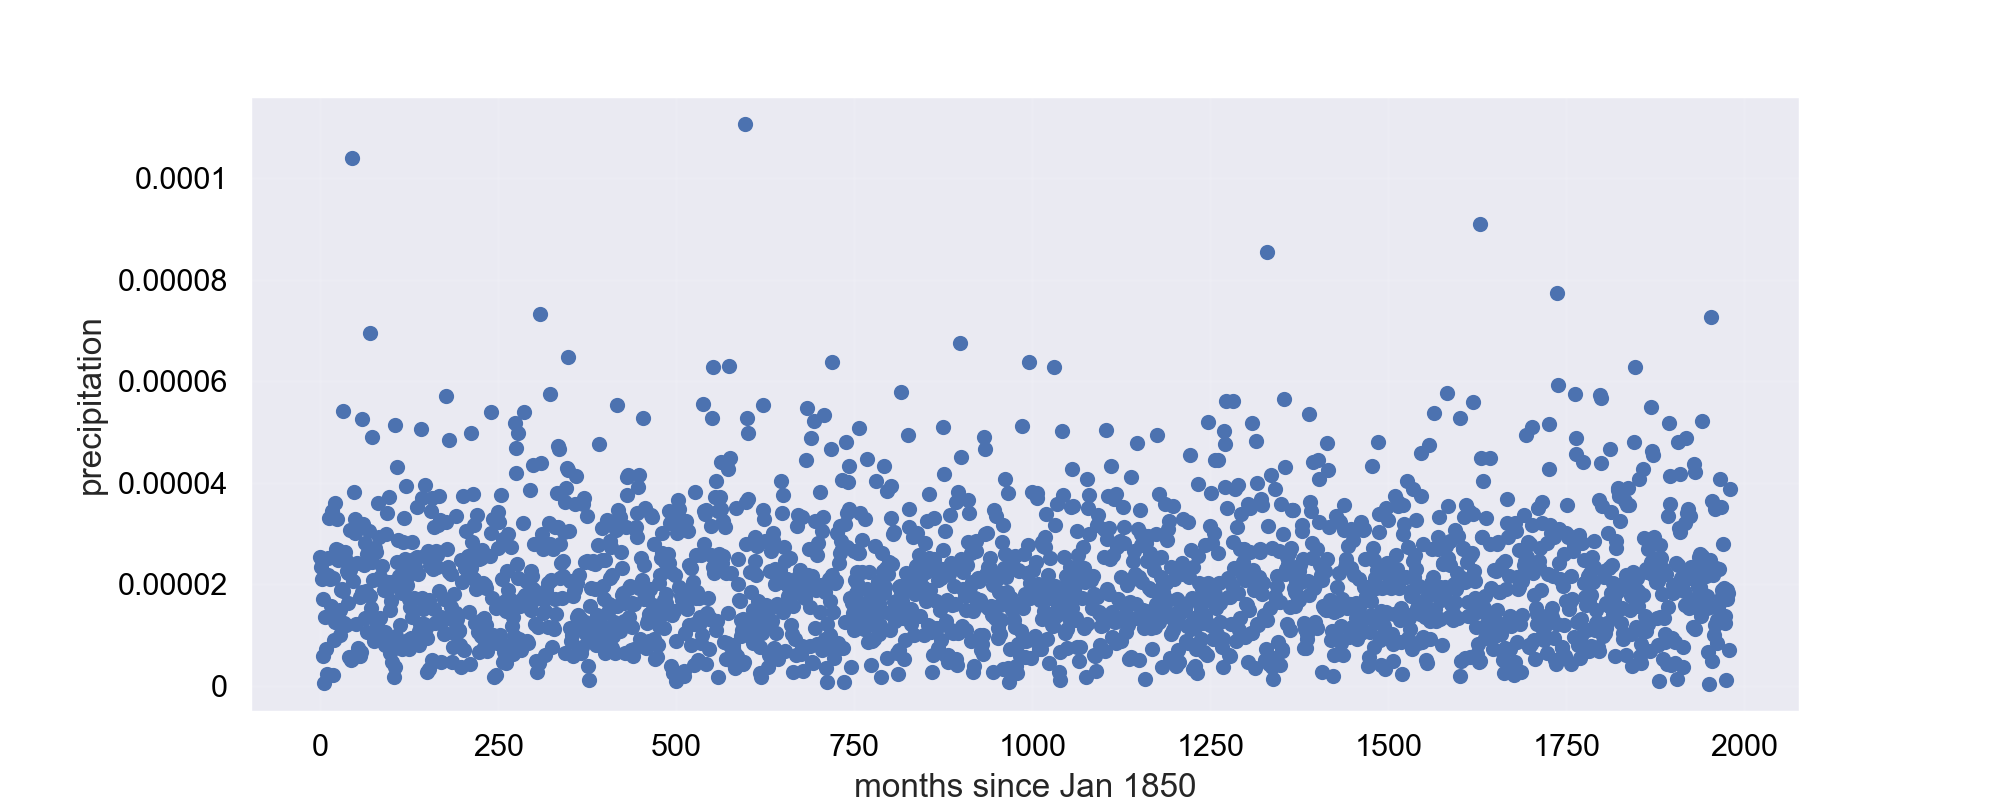

In [67]:
first_band.plot(x="time_bnds", xlabel="months since Jan 1850", y="pr", ylabel="precipitation", kind="scatter", figsize=(10, 4))

Let's try zooming into the first 100 months:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='months since Jan 1850', ylabel='precipitation'>

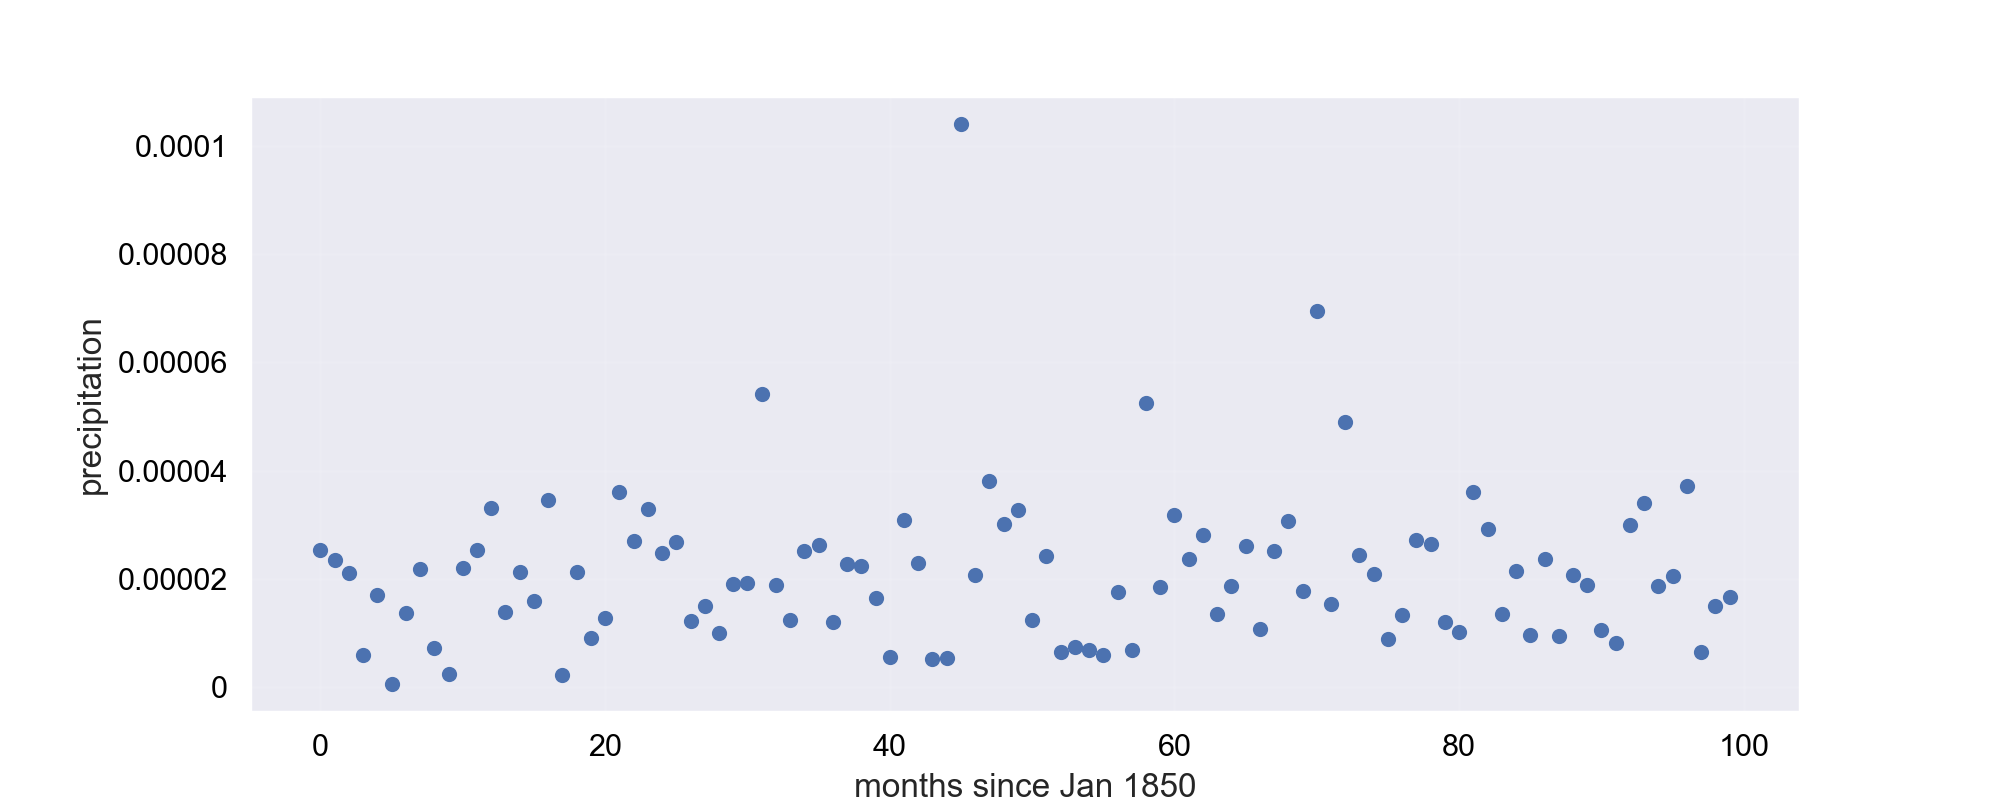

In [66]:
first_band[:100].plot(x="time_bnds", xlabel="months since Jan 1850", y="pr", ylabel="precipitation", kind="scatter", figsize=(10, 4))

### 1.4. Splitting the data into training-validation-test sets

Below, we use a 70%/10%/20% split for the training, validation and test sets, respectively. We'll fit the surrogate model on the training set, use the validation set to compute its accuracy and tweak its hyperparameters, then finally measure its accuracy on the test set.

In [26]:
training_set = df.loc[df.index.get_level_values("time") <= cftime.Datetime360Day(1965, 6, 16, 0, 0, 0, 0, has_year_zero=True)]
test_set = df.loc[df.index.get_level_values("time") >= cftime.Datetime360Day(1982, 1, 16, 0, 0, 0, 0, has_year_zero=True)]

In [27]:
validation_set = df.loc[(df.index.get_level_values("time") > cftime.Datetime360Day(1965, 6, 16, 0, 0, 0, 0, has_year_zero=True)) & (df.index.get_level_values("time") < cftime.Datetime360Day(1982, 1, 16, 0, 0, 0, 0, has_year_zero=True))]

## 2. Fitting a GP 

Again, we consider the precipitation measurements of one point in the UK situated at `51.875` latitude and `0.9375` longitude. 

For now, instead of using the entire dataset of 1980 monthly measurements, we fit the model to 36 months starting January 1850, and test it on the following 14 months.

In [50]:
keys = training_set['pr'].keys()
tuples = []
for element in keys:
    if element[0] == uk_latitude and element[2] == uk_longitude and element[1]==0:
        tuples.append(element)

In [51]:
Xtrain = np.arange(0, 36, 1)
Ytrain = np.array(training_set['pr'][tuples[:36]])*10**5
Xtest = np.arange(0, 50, 1)
Ytest = np.array(training_set['pr'][tuples[0:50]])*10**5

In this example, we use a combination of RBF and periodic Matérn kernels. The hyperparameters are chosen to give relatively good results experimentally, but are not optimised.

In [53]:
kernel = GPy.kern.RBF(1, lengthscale=2.6, variance=3.5) + GPy.kern.PeriodicMatern32(1, lengthscale=10, variance=3.5)
model = GPy.models.GPRegression(Xtrain.reshape(-1, 1), Ytrain.reshape(-1, 1), kernel=kernel, normalizer= True, noise_var=0.05)

Below we display the model (with all its associated parameters as they have been trained) and then plot the GP fit to the training data.

GP_regression.,value,constraints,priors
sum.rbf.variance,3.5,+ve,
sum.rbf.lengthscale,2.6,+ve,
sum.periodic_Matern32.variance,3.5,+ve,
sum.periodic_Matern32.lengthscale,10.0,+ve,
sum.periodic_Matern32.period,6.283185307179586,+ve,
Gaussian_noise.variance,0.05,+ve,


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f8e03ef2b80>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f8e03ef3490>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f8e03ef3940>]}

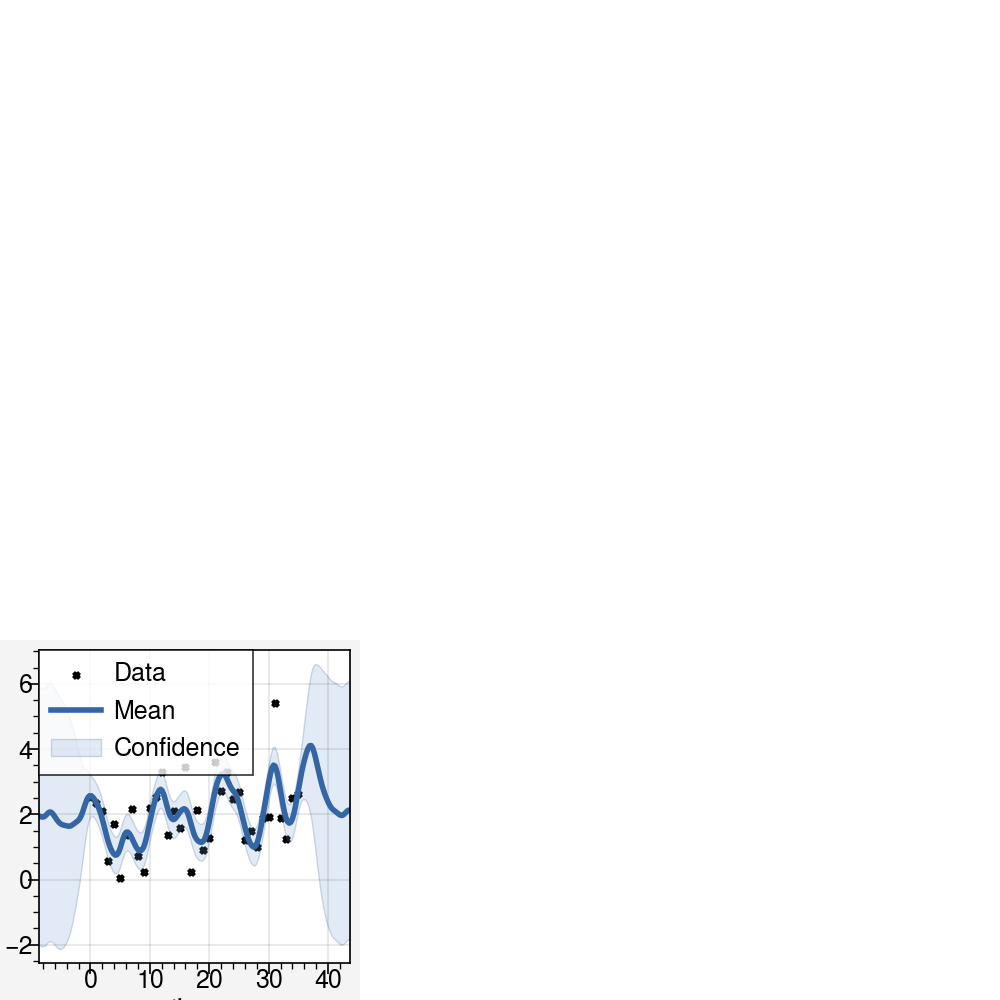

In [54]:
display(model)
model.plot(figsize=(5, 5), dpi=100, xlabel="time", ylabel="precipitation")

Finally, let's see how the fitted model predicts precipitation data on the 14 data points in the test set.

In [57]:
y_mean, y_std = model.predict(Xtest.reshape(-1, 1))

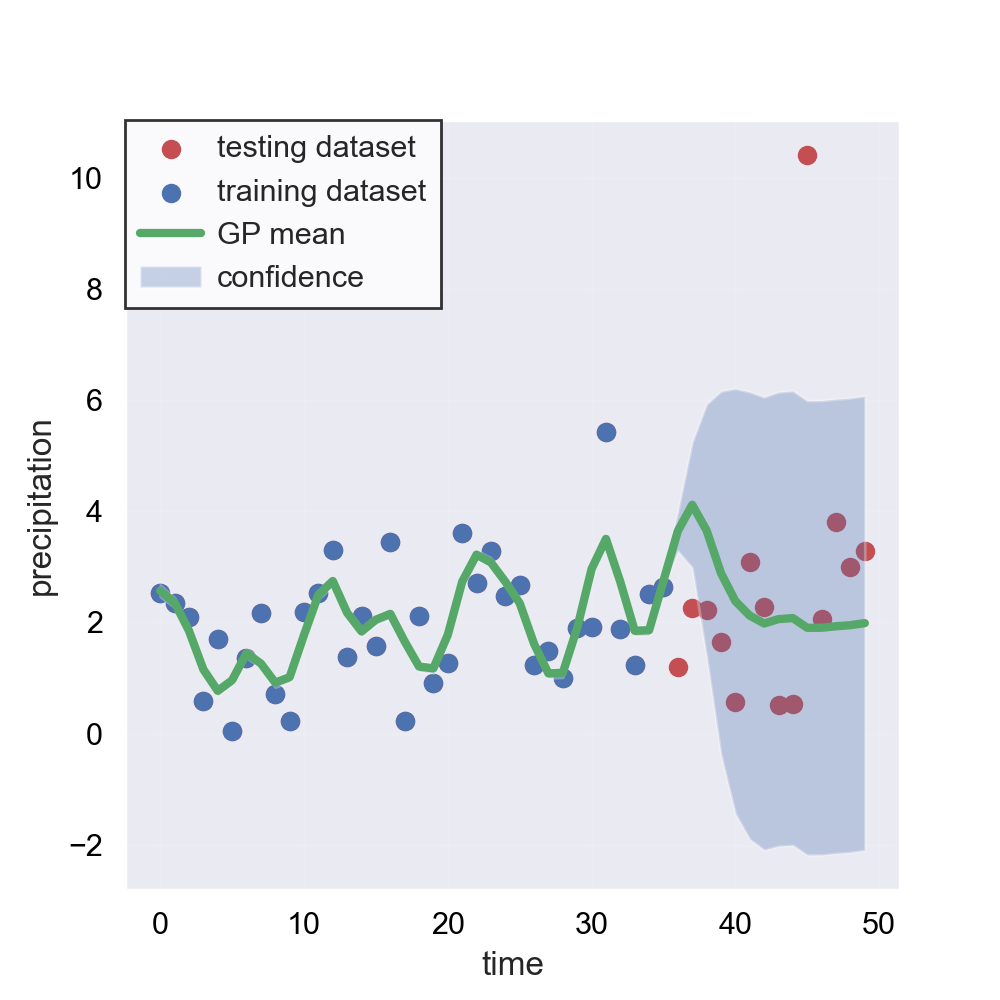

In [59]:
plt.figure(figsize=(5, 5), dpi=100)
sns.set()
plt.xlabel("time")
plt.ylabel("precipitation")
plt.scatter(Xtest, Ytest, lw=1, color="r", label="testing dataset")
plt.scatter(Xtrain, Ytrain, lw=1, color="b", label="training dataset")
plt.plot(Xtest, y_mean, lw=3, color="g", label="GP mean")
plt.fill_between(Xtest, (y_mean + y_std).reshape(y_mean.shape[0]), (y_mean - y_std).reshape(y_mean.shape[0]), facecolor="b", alpha=0.3, label="confidence")
plt.legend(loc="upper left")
plt.show()